These are moleculeNet benchmarks meant to sanity check our approaches

In [28]:
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import pandas as pd
import numpy as np
import io
from tqdm import tqdm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15, titlesize=20)
plt.rc('figure', titlesize=20)

n_seed = 10
data_p = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4")
# data_p = Path("/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results")


green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

n_colors=13
color_pal_list = [sns.color_palette(x[0], x[1]) for x in [("Spectral", n_colors),
                    ("brg", n_colors),
                 ("cool", n_colors),
                 ("gist_rainbow", n_colors),
                 ("hsv", n_colors),
                ("colorblind", n_colors)]]

color_pal = color_pal_list[5]
color_pal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]

In [29]:
color_dict = {
    "smiles-pe.atomwise.0": rocket_color_pal[2],
    "smiles-pe.bpe.0": rocket_color_pal[4],   
#     "smiles-pe.ngram.1": color_pal[0],
#     "selfies.None": "purple",
"selfies.atomwise": green_color_pal[4],
#     "selfies.selfies-charwise": color_pal[2],
    "ecfp": green_color_pal[6],
    "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
#     "openhd": "green",
    "mlp": blue_color_pal[7],
#     "Vina": color_pal[2]
}



marker_dict = {
#     "smiles-pe": "+",
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",   
#     "smiles-pe.ngram.1": "+",
    "selfies.atomwise": "*",
#     "selfies.selfies-charwise": "*",
    "ecfp": "+",
    "rp": "+",
    "rf": "^",
#     "openhd": "*",
    "mlp": "+",
#     "Vina": "+"
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
    ("selfies.atomwise", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
    ("ecfp", "HDBind-ECFP"),
    ("rp", "HDBind-RPFP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
    ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
    "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
    "selfies.atomwise": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
    "ecfp": "HDBind-ECFP",
    "rp": "HDBind-RPFP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina"
}


linestyle_dict = {
    "smiles-pe.atomwise.0": "-", 
    "smiles-pe.bpe.0": ":",
    "selfies.atomwise": "-",
    "ecfp": ":",
    "rp": "-.",
    "rf": "-",
    "mlp": ":",
    "Vina": "-"
}





def plot_confusion_matrix(y_pred, y_true, ax):

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0,1], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
    disp.plot(cmap="Purples", ax=ax)
    
    
    
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

    
def plot_dist_plot(y_score, y_true, ax):
    
    neg_dist = y_score[y_true == 0]
    pos_dist = y_score[y_true == 1]
    
    
    sns.distplot(neg_dist, color="blue", ax=ax)
    sns.distplot(pos_dist, color="red", ax=ax)
    

In [30]:
import torch 


def compute_average_roc_from_pkl(path):
    
#     fpr_list = []
#     tpr_list = []
    
    roc_list = []
    
    
    
#         data = pickle.load(path)  # In my case this call is buried deeper in torch-agnostic code
    with open(path, "rb") as handle:
        print(path)
#         data = pickle.load(handle)
        data = pickle.load(handle)


#         print(f"loading file {path}, with {len(data)-1} seeds to read")

#         '''
        for seed in range(n_seed):
        
            y_pred = data[seed]['y_pred']
            y_true = data[seed]['y_true']
            y_score = data[seed]['eta']

            score = None

            if y_score.squeeze().ndim < 2:
                score = y_score
            else:
                score = y_score[:, 1]

            fpr, tpr, thresholds = roc_curve(y_score=score, y_true=y_true)
            roc_auc = auc(fpr, tpr)

            roc_list.append(roc_auc)

        return np.mean(roc_list), np.std(roc_list)
#         '''

In [31]:
def bbbp_main():
    
    roc_f, roc_ax = plt.subplots(1,2, figsize=(16,6), sharex=True, sharey=True)


    for split_type, ax in [("random", roc_ax[0]), ("scaffold", roc_ax[1])]:
        model_dict = {"model": [], "roc-auc-mean": [], "roc-auc-std": []}

        for model, color in color_dict.items():

#             tqdm.write(f"{model}, {split_type}")

            data_path_list = list(data_p.glob(f"bbbp.{split_type}.{model}*pkl"))
        
            ax.set_title(split_type.capitalize())


            for path in tqdm(data_path_list, total=len(data_path_list)):

                name = str(path.name).split('.')[-2]     
                roc_auc_mean, roc_auc_std = compute_average_roc_from_pkl(path)

                model_dict["model"].append(model)
                model_dict["roc-auc-mean"].append(roc_auc_mean)
                model_dict["roc-auc-std"].append(roc_auc_std)

            df = pd.DataFrame(model_dict)

        
            df["model_name"] = df["model"].apply(lambda x: model_name_dict[x])
            df["color"] = df["model"].apply(lambda x: color_dict[x])

            bars = ax.bar(data=df, x="model", height="roc-auc-mean", yerr="roc-auc-std", color=[color_dict[x] for x in df['model'].values],
                         hatch="/")
            ax.tick_params(axis="x", labelrotation=25)
            ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


    roc_ax[0].set_title("Random", fontdict={"fontsize": 20})
    roc_ax[1].set_title("Scaffold", fontdict={"fontsize": 20})
    
    roc_ax[0].set_ylabel("ROC-AUC")

    plt.tight_layout()
    plt.savefig(f"bbbp_roc.png", dpi=600, bbox_inches="tight")


100%|██████████| 1/1 [00:00<00:00, 18.75it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.random.smiles-pe.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 33.72it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.random.smiles-pe.bpe.0.pkl


100%|██████████| 1/1 [00:00<00:00, 31.80it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.random.selfies.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 34.04it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.random.ecfp.atomwise.0.pkl


  0%|          | 0/1 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.random.rp.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 34.60it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])
100%|██████████| 1/1 [00:00<00:00, 77.57it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.random.rf.None.0.pkl


  0%|          | 0/1 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.random.mlp.None.0.pkl


100%|██████████| 1/1 [00:00<00:00, 28.47it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])
100%|██████████| 1/1 [00:00<00:00, 35.02it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.scaffold.smiles-pe.atomwise.0.pkl


  0%|          | 0/1 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.scaffold.smiles-pe.bpe.0.pkl


100%|██████████| 1/1 [00:00<00:00, 25.12it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])
100%|██████████| 1/1 [00:00<00:00, 33.23it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.scaffold.selfies.atomwise.0.pkl



/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])
  0%|          | 0/1 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.scaffold.ecfp.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 28.13it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])
  0%|          | 0/1 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.scaffold.rp.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 31.05it/s]
/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])
100%|██████████| 1/1 [00:00<00:00, 80.39it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.scaffold.rf.None.0.pkl


/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])
100%|██████████| 1/1 [00:00<00:00, 27.99it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/bbbp.scaffold.mlp.None.0.pkl


/tmp/ipykernel_2299244/2283127535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


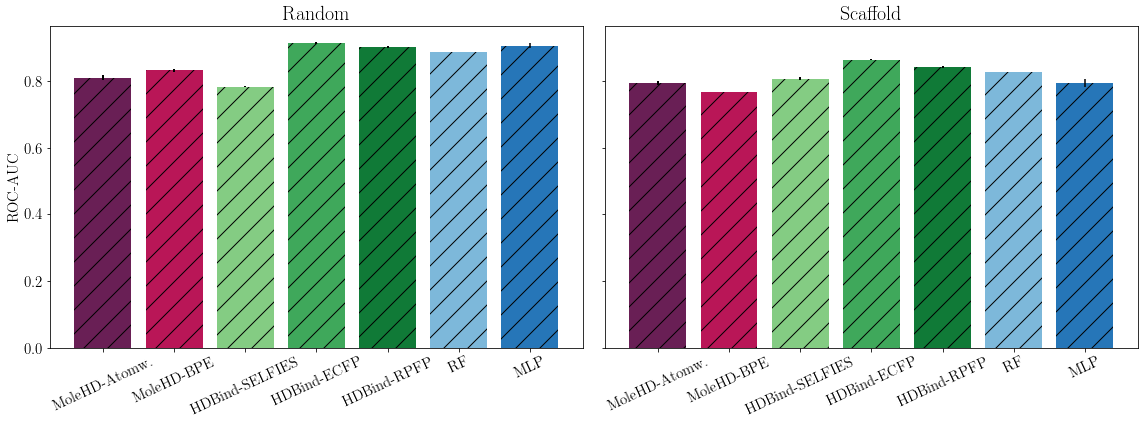

In [32]:
bbbp_main()

In [33]:
def sider_main():
    
    sider_f, sider_ax = plt.subplots(1,2, figsize=(16,6), sharex=True, sharey=True)
    sider_ax = sider_ax.flatten()
    
    
    model_dict = {"model": [], "task": [], "roc-auc-mean": [], "roc-auc-std": []}

    for split_type, ax in [("random", sider_ax[0]), ("scaffold", sider_ax[1])]:
        ax.set_title(split_type.capitalize())

        for model, color in color_dict.items():
            
            data_path_list = list(data_p.glob(f"sider.*.{split_type}.{model}*pkl"))

            print(f"{model}-{split_type}-{len(data_path_list)}")
            for path in tqdm(data_path_list, total=len(data_path_list)):
                                
                try:
                
                        name = str(path.name).split('.')[-2]
                
                        task = int(str(path.name).split('.')[1].split('_')[-1])
            
                        roc_auc_mean, roc_auc_std = compute_average_roc_from_pkl(path)

                        model_dict["model"].append(model)
                        model_dict["task"].append(task)
                        model_dict["roc-auc-mean"].append(roc_auc_mean)
                        model_dict["roc-auc-std"].append(roc_auc_std)
                
                except Exception as e:
                    print(e)
                    continue


        df = pd.DataFrame(model_dict)
        print(df.shape)

        g = sns.boxplot(data=df, x="model", y="roc-auc-mean", ax=ax, palette=color_dict)

    for ax in sider_ax:
        ax.tick_params(axis="x", labelrotation=25)
        labels = [x for x in ax.get_xticklabels()]
        labels = [model_name_dict[x.get_text()] for x in labels]
        ax.set_xticklabels(labels)
        ax.set_ylabel("")
        ax.set_xlabel("")
    
    sider_ax[0].set_title("Random", fontdict={"fontsize": 20})
    sider_ax[1].set_title("Scaffold", fontdict={"fontsize": 20})
    
    sider_ax[0].set_ylabel("ROC-AUC")
        
    plt.tight_layout()
    sider_f.savefig(f"sider_roc.png", dpi=600, bbox_inches="tight")


smiles-pe.atomwise.0-random-27


 11%|█         | 3/27 [00:00<00:00, 25.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.random.smiles-pe.atomwise.0.pkl


 41%|████      | 11/27 [00:00<00:00, 31.72it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.random.smiles-pe.atomwise.0.pkl


 70%|███████   | 19/27 [00:00<00:00, 32.43it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.random.smiles-pe.atomwise.0.pkl


100%|██████████| 27/27 [00:00<00:00, 32.56it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.random.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.random.smiles-pe.atomwise.0.pkl
smiles-pe.bpe.0-random-27



 11%|█         | 3/27 [00:00<00:01, 22.67it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.random.smiles-pe.bpe.0.pkl


 37%|███▋      | 10/27 [00:00<00:00, 27.18it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.random.smiles-pe.bpe.0.pkl


 67%|██████▋   | 18/27 [00:00<00:00, 31.08it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.random.smiles-pe.bpe.0.pkl


 96%|█████████▋| 26/27 [00:00<00:00, 32.92it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.random.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.random.smiles-pe.bpe.0.pkl


100%|██████████| 27/27 [00:00<00:00, 30.95it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.random.smiles-pe.bpe.0.pkl
selfies.atomwise-random-27


  7%|▋         | 2/27 [00:00<00:01, 19.38it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.random.selfies.atomwise.0.pkl


 22%|██▏       | 6/27 [00:00<00:01, 20.99it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.random.selfies.atomwise.0.pkl


 33%|███▎      | 9/27 [00:00<00:00, 21.28it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.random.selfies.atomwise.0.pkl


 48%|████▊     | 13/27 [00:00<00:00, 23.74it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.random.selfies.atomwise.0.pkl


 63%|██████▎   | 17/27 [00:00<00:00, 27.14it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.random.selfies.atomwise.0.pkl


 89%|████████▉ | 24/27 [00:00<00:00, 27.72it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.random.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.random.selfies.atomwise.0.pkl


100%|██████████| 27/27 [00:01<00:00, 25.86it/s]


ecfp-random-27


 15%|█▍        | 4/27 [00:00<00:00, 33.96it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.random.ecfp.atomwise.0.pkl


 30%|██▉       | 8/27 [00:00<00:00, 33.42it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.random.ecfp.atomwise.0.pkl


 44%|████▍     | 12/27 [00:00<00:00, 30.36it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.random.ecfp.atomwise.0.pkl


 59%|█████▉    | 16/27 [00:00<00:00, 31.55it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.random.ecfp.atomwise.0.pkl


 89%|████████▉ | 24/27 [00:00<00:00, 32.44it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.random.ecfp.atomwise.0.pkl


100%|██████████| 27/27 [00:00<00:00, 32.87it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.random.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.random.ecfp.atomwise.0.pkl
rp-random-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.random.rp.atomwise.0.pkl


 15%|█▍        | 4/27 [00:00<00:00, 32.30it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.random.rp.atomwise.0.pkl


 30%|██▉       | 8/27 [00:00<00:00, 32.70it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.random.rp.atomwise.0.pkl


 44%|████▍     | 12/27 [00:00<00:00, 28.55it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.random.rp.atomwise.0.pkl


 59%|█████▉    | 16/27 [00:00<00:00, 30.48it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.random.rp.atomwise.0.pkl


 74%|███████▍  | 20/27 [00:00<00:00, 33.29it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.random.rp.atomwise.0.pkl


 89%|████████▉ | 24/27 [00:00<00:00, 32.82it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.random.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.random.rp.atomwise.0.pkl


100%|██████████| 27/27 [00:00<00:00, 31.27it/s]


rf-random-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.random.rf.None.0.pkl


 33%|███▎      | 9/27 [00:00<00:00, 85.70it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdp

 67%|██████▋   | 18/27 [00:00<00:00, 86.79it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.random.rf.None.0.pkl


100%|██████████| 27/27 [00:00<00:00, 86.36it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.random.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.random.rf.None.0.pkl
mlp-random-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.random.mlp.None.0.pkl


 11%|█         | 3/27 [00:00<00:00, 29.53it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.random.mlp.None.0.pkl


 26%|██▌       | 7/27 [00:00<00:00, 30.92it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.random.mlp.None.0.pkl


 41%|████      | 11/27 [00:00<00:00, 30.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.random.mlp.None.0.pkl


 56%|█████▌    | 15/27 [00:00<00:00, 27.51it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.random.mlp.None.0.pkl


 67%|██████▋   | 18/27 [00:00<00:00, 26.40it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.random.mlp.None.0.pkl


 81%|████████▏ | 22/27 [00:00<00:00, 28.15it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.random.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.random.mlp.None.0.pkl


100%|██████████| 27/27 [00:00<00:00, 28.81it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.random.mlp.None.0.pkl
(189, 4)
smiles-pe.atomwise.0-scaffold-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.scaffold.smiles-pe.atomwise.0.pkl


 22%|██▏       | 6/27 [00:00<00:00, 57.56it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.scaffold.smiles-pe.atomwise.0.pkl


 44%|████▍     | 12/27 [00:00<00:00, 36.86it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.scaffold.smiles-pe.atomwise.0.pkl


 67%|██████▋   | 18/27 [00:00<00:00, 43.90it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/worksp

 85%|████████▌ | 23/27 [00:00<00:00, 44.91it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.scaffold.smiles-pe.atomwise.0.pkl


100%|██████████| 27/27 [00:00<00:00, 46.11it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.scaffold.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.scaffold.smiles-pe.atomwise.0.pkl
smiles-pe.bpe.0-scaffold-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.scaffold.smiles-pe.bpe.0.pkl


 15%|█▍        | 4/27 [00:00<00:00, 34.86it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.scaffold.smiles-pe.bpe.0.pkl


 33%|███▎      | 9/27 [00:00<00:00, 41.62it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.scaffold.smiles-pe.bpe.0.pkl


 56%|█████▌    | 15/27 [00:00<00:00, 43.91it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.scaffold.smiles-pe.bpe.0.pkl


 74%|███████▍  | 20/27 [00:00<00:00, 40.26it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.scaffold.smiles-pe.bpe.0.pkl


 93%|█████████▎| 25/27 [00:00<00:00, 41.16it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.scaffold.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.scaffold.smiles-pe.bpe.0.pkl


100%|██████████| 27/27 [00:00<00:00, 41.42it/s]


selfies.atomwise-scaffold-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.scaffold.selfies.atomwise.0.pkl


 19%|█▊        | 5/27 [00:00<00:00, 45.87it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.scaffold.selfies.atomwise.0.pkl


 48%|████▊     | 13/27 [00:00<00:00, 62.19it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.scaffold.selfies.atomwise.0.pkl


 74%|███████▍  | 20/27 [00:00<00:00, 52.04it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.scaffold.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.scaffold.selfies.atomwise.0.pkl


 96%|█████████▋| 26/27 [00:00<00:00, 46.48it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.scaffold.selfies.atomwise.0.pkl


100%|██████████| 27/27 [00:00<00:00, 48.25it/s]


ecfp-scaffold-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.scaffold.ecfp.atomwise.0.pkl


 22%|██▏       | 6/27 [00:00<00:00, 58.78it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.scaffold.ecfp.atomwise.0.pkl


 44%|████▍     | 12/27 [00:00<00:00, 52.30it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.scaffold.ecfp.atomwise.0.pkl


 67%|██████▋   | 18/27 [00:00<00:00, 54.50it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.t

100%|██████████| 27/27 [00:00<00:00, 51.24it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.scaffold.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.scaffold.ecfp.atomwise.0.pkl
rp-scaffold-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.scaffold.rp.atomwise.0.pkl


 26%|██▌       | 7/27 [00:00<00:00, 65.30it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.scaffold.rp.atomwise.0.pkl


 52%|█████▏    | 14/27 [00:00<00:00, 42.79it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.scaffold.rp.atomwise.0.pkl


 78%|███████▊  | 21/27 [00:00<00:00, 48.80it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.scaffold.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.scaffold.rp.atomwise.0.pkl


100%|██████████| 27/27 [00:00<00:00, 47.53it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.scaffold.rp.atomwise.0.pkl
rf-scaffold-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.scaffold.rf.None.0.pkl


 33%|███▎      | 9/27 [00:00<00:00, 86.89it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.scaffold.rf.None.0.pkl
/g/g13/jones289/workspa

 67%|██████▋   | 18/27 [00:00<00:00, 88.62it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.scaffold.rf.None.0.pkl


100%|██████████| 27/27 [00:00<00:00, 88.59it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.scaffold.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.scaffold.rf.None.0.pkl
mlp-scaffold-27


  0%|          | 0/27 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_6.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_24.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_10.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_14.scaffold.mlp.None.0.pkl


 15%|█▍        | 4/27 [00:00<00:00, 33.12it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_20.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_2.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_18.scaffold.mlp.None.0.pkl


 30%|██▉       | 8/27 [00:00<00:00, 32.39it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_9.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_13.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_5.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_1.scaffold.mlp.None.0.pkl


 44%|████▍     | 12/27 [00:00<00:00, 30.98it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_23.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_17.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_19.scaffold.mlp.None.0.pkl


 59%|█████▉    | 16/27 [00:00<00:00, 32.60it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_11.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_7.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_25.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_21.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_3.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_15.scaffold.mlp.None.0.pkl


 74%|███████▍  | 20/27 [00:00<00:00, 31.22it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_26.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_4.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_12.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_16.scaffold.mlp.None.0.pkl


 89%|████████▉ | 24/27 [00:00<00:00, 31.79it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_0.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_22.scaffold.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/sider.task_8.scaffold.mlp.None.0.pkl


100%|██████████| 27/27 [00:00<00:00, 31.59it/s]

(378, 4)


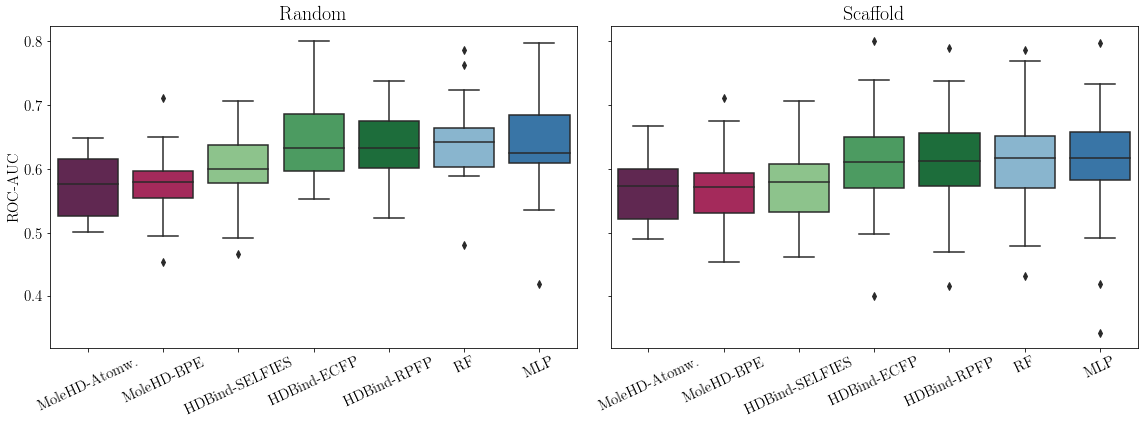

In [34]:
sider_main()

In [35]:
def clintox_main():    
    
    clintox_f, clintox_ax = plt.subplots(1,2, figsize=(16,6), sharex=True, sharey=True)
    
    for split_type, ax in [("random", clintox_ax[0]), ("scaffold", clintox_ax[1])]:
        model_dict = {"model": [], "task": [], "roc-auc-mean": [], "roc-auc-std": []}
        ax.set_title(split_type.capitalize())

        for model, color in color_dict.items():

            data_path_list = list(data_p.glob(f"clintox.task_0.{split_type}.{model}*.pkl"))        

            for path in tqdm(data_path_list):
                with open(path, "rb") as handle:

                    data = pickle.load(handle)
                    name = str(path.name).split('.')[-2]


                    task = int(str(path.name).split('.')[1].split('_')[-1])
                    roc_auc_mean, roc_auc_std = compute_average_roc_from_pkl(path)


                    model_dict["model"].append(model)
                    model_dict["task"].append(task)
                    model_dict["roc-auc-mean"].append(roc_auc_mean)
                    model_dict["roc-auc-std"].append(roc_auc_std)


        df = pd.DataFrame(model_dict)
        df["model_name"] = df["model"].apply(lambda x: model_name_dict[x])
        df["color"] = df["model"].apply(lambda x: color_dict[x])

        bars = ax.bar(data=df, x="model", height="roc-auc-mean", yerr="roc-auc-std", color=[color_dict[x] for x in df['model'].values],
                     hatch="x")
        ax.tick_params(axis="x", labelrotation=25)
        ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])

    clintox_ax[0].set_ylabel("ROC-AUC")

        
    plt.tight_layout()
    clintox_f.savefig(f"clintox_roc.png", dpi=600, bbox_inches="tight")


100%|██████████| 1/1 [00:00<00:00, 33.05it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.random.smiles-pe.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 27.55it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.random.smiles-pe.bpe.0.pkl


100%|██████████| 1/1 [00:00<00:00, 33.29it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.random.selfies.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 33.73it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.random.ecfp.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.random.rp.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 81.76it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.random.rf.None.0.pkl


  0%|          | 0/1 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.random.mlp.None.0.pkl


100%|██████████| 1/1 [00:00<00:00, 32.65it/s]
/tmp/ipykernel_2299244/2990216876.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])
100%|██████████| 1/1 [00:00<00:00, 76.65it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.scaffold.smiles-pe.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 86.85it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.scaffold.smiles-pe.bpe.0.pkl


100%|██████████| 1/1 [00:00<00:00, 82.44it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.scaffold.selfies.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 78.59it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.scaffold.ecfp.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 76.97it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.scaffold.rp.atomwise.0.pkl


100%|██████████| 1/1 [00:00<00:00, 78.42it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.scaffold.rf.None.0.pkl


  0%|          | 0/1 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/clintox.task_0.scaffold.mlp.None.0.pkl


100%|██████████| 1/1 [00:00<00:00, 33.77it/s]
/tmp/ipykernel_2299244/2990216876.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([model_name_dict[x] for x in df['model'].values])


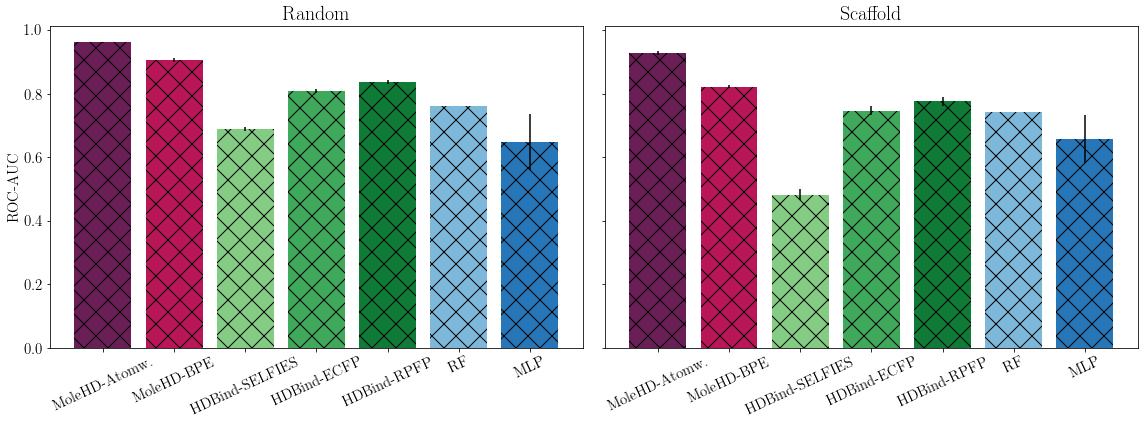

In [36]:
clintox_main()

I wonder if there is a bias in the smiles string itself that separates the positive from negative classes almost linearly? Especially since the raw smiles uni-gram model is the best here?